In [41]:
import pandas as pd
import seaborn as sns
import os
import glob
import tqdm
import matplotlib.pyplot as plt

In [42]:
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1.5)

In [43]:
# path = 'vm108_val_midtri_1024x576.xlsx'
path = 'vm108_val_midtri_256.xlsx'
df = pd.read_excel(path, sheet_name=None)['avg_clip']
df = df.rename(columns={df.columns[0]: 'metric'})
df.index = df['metric']

In [44]:
models = df.columns[1:].tolist()
names, frames = zip(*[(k.rsplit('_mem', maxsplit=1)) for k in models if '_mem' in k and k[-1]=='f'])
names = list(set(names))
frames = sorted([int(i[:-1]) for i in list(set(frames)) if i[:-1].isdigit()])
frames

[1, 30, 60, 120, 240, 480]

In [45]:
# TODO: select some models only
names = [i for i in names if 'STCN' not in i]
names

['GFM_GatedFuseVM_4xfoucs_randmemtrimap',
 'GFM_GatedFuseVM_4xfoucs',
 'TCVOM_GCA_TAM']

In [46]:
metric_dfs = {}
avg_dfs = {}
for model in names:
    # print(model+"_mem30f" in df.columns)
    cols = [(f'mem{f}f', col) for f in frames if (col:=f'{model}_mem{f}f') in df.columns]
    cols.append(('first_only', model))
    # print(cols)
    idx, cols = zip(*cols)
    model_df = df[list(cols)]
    model_df.columns = idx
    avg_dfs[model] = model_df
metric = model_df.index

In [47]:
avg_dfs.keys()

dict_keys(['GFM_GatedFuseVM_4xfoucs_randmemtrimap', 'GFM_GatedFuseVM_4xfoucs', 'TCVOM_GCA_TAM'])

In [48]:
avg_dfs[next(iter(avg_dfs))]

,mem1f,mem30f,mem60f,mem120f,mem240f,mem480f,first_only
metric,,,,,,,
tran_pha_sad,1542.267333,1604.699175,1647.420652,1659.577095,1699.434140,1783.399677,1847.824697
tran_pha_mse,14.156080,16.683045,17.579876,18.020983,19.109797,20.964984,22.000181
tran_pha_mad,48.601334,51.634801,53.175945,54.001615,55.732236,58.726447,60.982484
tran_pha_grad,1.293466,1.488161,1.555793,1.594376,1.636072,1.692112,1.734704
tran_pha_dtssd,4.152757,4.487123,4.543244,4.574862,4.637947,4.666400,4.732074
pha_sad,1552.505678,1634.161234,1686.959769,1716.155971,1772.971734,1898.378880,1982.034802
pha_mse,5.916112,6.779786,7.160396,7.309545,7.699636,8.578885,9.102922
pha_mad,23.689357,24.935322,25.740963,26.186462,27.053402,28.966963,30.243451
pha_grad,1.331931,1.540191,1.615044,1.666144,1.716297,1.778993,1.834992


In [62]:
name_dict = {
    'GFM_GatedFuseVM_4xfoucs': 'Fixed dilation width',
    'GFM_GatedFuseVM_4xfoucs_randmemtrimap': 'Smaller dilation width',
    # 'TCVOM_GCA_TAM': 'TCVOM GCA TAM',
    # 'ft_TCVOM_GCA_TAM': 'TCVOM Finetune',
}

In [50]:
def sort_time(df):
    time_order = [f'mem{f}f' for f in frames] + ['first_only']
    return df.reindex(time_order)

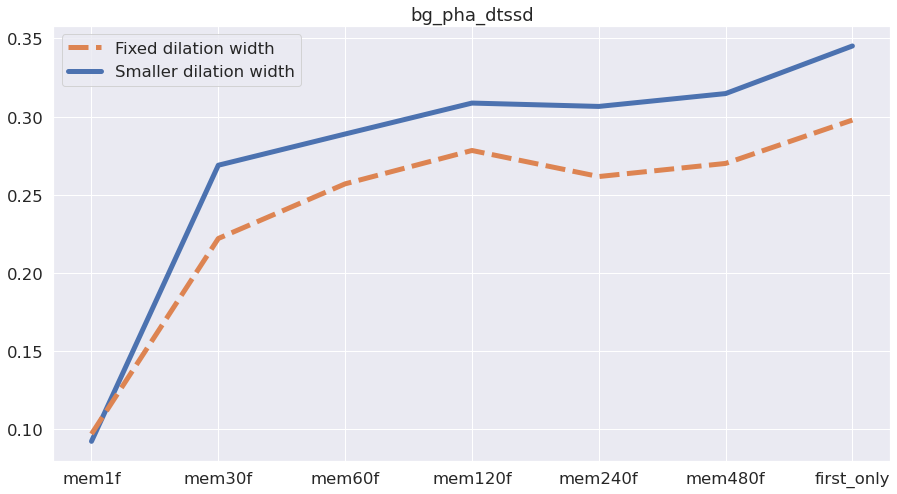

In [64]:
def run_fig(avg_dfs, name_dict, metric, save_path=''):
    # for metric in avg_dfs[next(iter(avg_dfs))]
    # df = pd.DataFrame({k: v.loc[metric] for k, v in avg_dfs.items()})
    df = pd.DataFrame({name_dict[k]: v.loc[metric] for k, v in avg_dfs.items() if k in name_dict})
    # df = pd.DataFrame({name_dict[k]: v[metric] for k, v in avg_dfs.items()})
    df = sort_time(df)
    # plt.figure()
    plt.clf()
    lp = sns.lineplot(data=df, linewidth=5)
    lp.set(title=f'{metric}')
    # lp.set(ylim=(15, 35))
    d = {l:h for h, l in zip(*lp.get_legend_handles_labels())}
    h, l = zip(*[(d[k], k) for k in name_dict.values()])
    for leg in lp.legend(h, l).get_lines():
        leg.set_linewidth(5)
    if save_path != '':
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, metric+".png"), bbox_inches='tight')
# metric = 'pha_grad'
# run_fig(avg_dfs, name_dict, 'pha_mad')
for metric in avg_dfs[next(iter(avg_dfs))].index:
    run_fig(avg_dfs, name_dict, metric, 'figs_randmemtrimap')
    # break

In [52]:
def plot_hist(score):
    df = score.melt(value_vars=score.columns).dropna()
    sns.displot(data=df, col='variable', x='value', multiple='dodge', bins=10)
    sns.set(rc={'figure.figsize':(8, 8)})
    # sns.set_context(
    #     # "notebook", 
    #     font_scale=2, 
    #     rc={"lines.linewidth": 2, 'figure.figsize':(26,18)}
    # )
df = pd.DataFrame({
    'TCVOM': metric_dfs['TCVOM_GCA_TAM']['pha_dtssd']['mem30f'],
    'GFM GatedFuseVM(TempCons)': metric_dfs['GFM_GatedFuseVM_temp_cons']['pha_dtssd']['mem30f']
})
plot_hist(df)

KeyError: 'TCVOM_GCA_TAM'

In [ ]:
lp = sns.lineplot(data=df, linewidth=5)
for leg in lp.legend().get_lines():
    leg.set_linewidth(5)